we want to minimize Risk for every possible Returns with this conditions: 

\begin{document}
\begin{equation*}
\min \text{Risk}
\end{equation*}
\\
\begin{equation*}
\sum_{i=1}^{N} W_i = 1
\end{equation*}
\\

\begin{equation*}
0 \leq W_i \leq 1 \quad \text{for} \quad i = 1, 2, \dots, N
\end{equation*}
\end{document}

[*********************100%***********************]  5 of 5 completed


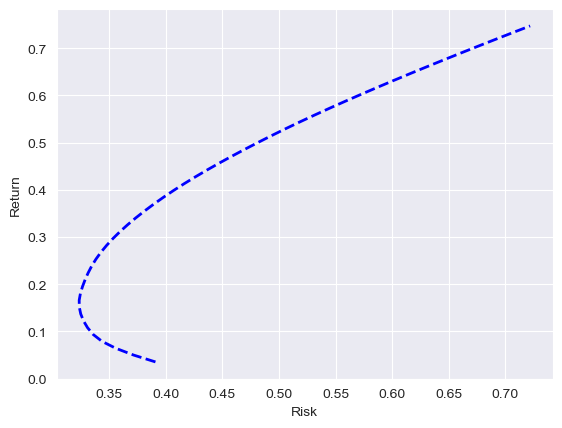

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]

data = yf.download(symbols, start="2020-01-01", end="2023-01-01")['Adj Close']

returns = data.pct_change().dropna()

mean_returns = returns.mean() * 252  
cov_matrix = returns.cov() * 252  

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def minimize_volatility(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_return})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1], 
                      num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    frontier_volatility = []
    frontier_returns = []
    
    for target_return in returns_range:
        result = minimize_volatility(mean_returns, cov_matrix, target_return)
        if result.success:
            ret, vol = portfolio_performance(result.x, mean_returns, cov_matrix)
            frontier_returns.append(ret)
            frontier_volatility.append(vol)
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.plot(frontier_volatility, frontier_returns, 'b--', linewidth=2, label="Efficient Frontier")
    

returns_range = np.linspace(mean_returns.min(), mean_returns.max(), 50)

efficient_frontier(mean_returns, cov_matrix, returns_range)

Based on different combinations of weights, we arrive at different slopes for the CML line. Therefore, we need to find the weights that maximize this slope. Once again, we are dealing with an optimization problem.
\begin{equation*}
\[
E(R_P) = R_f + \left( \frac{E(R_M) - R_f}{\sigma_M} \right) \sigma_P
\]
\\
\min -\left( \frac{E(R_M) - R_f}{\sigma_M} \right)

\end{equation*}

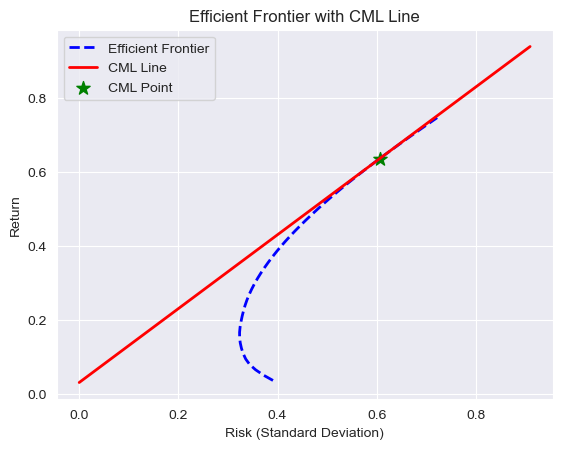

Optimal Weights: [2.26025422e-01 2.08166817e-17 0.00000000e+00 1.47451495e-17
 7.73974578e-01]
Optimal Return: 0.636525314045936
Optimal Risk: 0.6062882863289312


In [11]:
def sharpe_ratio(weights, mean_returns, cov_matrix, rf=0.03):
    port_return, port_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return (port_return - rf) / port_risk

# Optimize sharp ratio 
def maximize_sharpe_ratio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(lambda x: -sharpe_ratio(x, mean_returns, cov_matrix), 
                      num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_result = maximize_sharpe_ratio(mean_returns, cov_matrix)
optimal_weights = optimal_result.x

optimal_return, optimal_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

rf = 0.03

def tangent_line(x, rf, optimal_return, optimal_risk):
    return rf + (optimal_return - rf) / optimal_risk * x

returns_range = np.linspace(mean_returns.min(), mean_returns.max(), 50)


efficient_frontier(mean_returns, cov_matrix, returns_range)

x_vals = np.linspace(0, optimal_risk * 1.5 , 50) 
y_vals = tangent_line(x_vals, rf, optimal_return, optimal_risk)

plt.plot(x_vals, y_vals, 'r-', linewidth=2, label="CML Line")

plt.scatter(optimal_risk, optimal_return, color='green', marker='*', s=100, label="CML Point")
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier with CML Line')
plt.legend()
plt.show()

print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Return: {optimal_return}")
print(f"Optimal Risk: {optimal_risk}")